# Gradient Boosting for Titantic Data Set
by [Sonjoy Das, PhD](https://www.linkedin.com/in/sonjoydas/)

## Imports

In [1]:
import numpy as np
import pandas as pd
# import scipy
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.tree import DecisionTreeRegressor

# explicitly require this experimental feature to use IterativeImputer
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.ensemble import RandomForestRegressor
# from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

from sklearn.model_selection import train_test_split
# from sklearn import tree
# from IPython.display import Image
# %matplotlib inline
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score, RocCurveDisplay

## Gradient Boosting

You may recall that we last encountered gradients when discussing the gradient descent algorithm in the context of fitting linear regression models.  For a particular regression model with n parameters, an n+1 dimensional space existed defined by all the parameters plus the cost/loss function to minimize.  The combination of parameters and loss function define a surface within the space.  The regression model is fitted by moving down the steepest 'downhill' gradient until we reach the lowest point of the surface, where all possible gradients are 'uphill.'  The final model is made up of the parameter estimates that define that location on the surface.

Throughout all iterations of the gradient descent algorithm for linear regression, one thing remains constant: The underlying data used to estimate the parameters and calculate the loss function never changes.  In gradient boosting, however, the underlying data do change.  

**Each time we run a decision tree, we extract the residuals.  Then we run a new decision tree, using those residuals as the outcome to be predicted**.  After reaching a stopping point, we add together the predicted values from all of the decision trees to create the final gradient boosted prediction.

Gradient boosting can work on any combination of loss function and model type, as long as we can calculate the derivatives of the loss function with respect to the model parameters.  Most often, however, gradient boosting uses decision trees, and minimizes either the  residual (regression trees) or the negative log-likelihood (classification trees).  

Let’s go through a simple regression example using Decision Trees as the base predictors (of course Gradient Boosting also works great with regression tasks). This is called Gradient Tree Boosting, or Gradient Boosted Regression Trees. First, let’s fit a `DecisionTreeRegressor` to the training set.

In [2]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [3]:
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now train a second `DecisionTreeRegressor` on the residual errors made by the first predictor:

In [4]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

Then, we train a third regressor on the residual errors made by the second predictor:



In [5]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now we have **an ensemble containing three trees**. It can make predictions on a new instance simply by adding up the predictions of all the trees:

In [6]:
X_new = np.array([[0.8]])

In [7]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [8]:
y_pred

array([0.75026781])

The figure below represents the predictions of these three trees in the left column, and the ensemble’s predictions in the right column. In the first row, the ensemble has just one tree, so its predictions are exactly the same as the first tree’s predictions. In the second row, a new tree is trained on the residual errors of the first tree. On the right you can see that the ensemble’s predictions are equal to the sum of the predictions of the first two trees. Similarly, in the third row another tree is trained on the residual errors of the second tree. You can see that the ensemble’s predictions gradually get better as trees are added to the ensemble.

**<font color='teal'>Run the below cell to develop a visual representation.</font>**

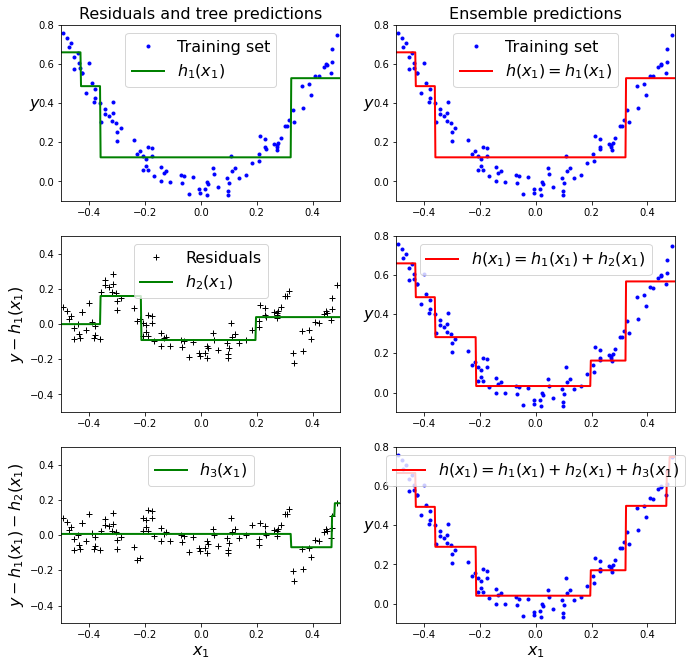

In [9]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

#save_fig("gradient_boosting_plot")
plt.show()

## Load and Explore Data

Now that you have solid understanding of Gradient Boosting in the regression scenario, let's apply the same algorithm to a classification problem. Specifically, the Titanic dataset and predicting survival.

**<font color='teal'>Use pandas read csv to load in the Titantic data set into a dataframe called df.</font>**

Note: In this case you can use [dropna()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html) to just throw away any incomplete rows. For the purpose of simple illustration, we may disregard them but obviously in the real world we need to be much more careful and decide how to handle incomplete observations. Here, we will **not** disregard them.

In [10]:
df = pd.read_csv('titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
df.shape

(891, 12)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [14]:
df.describe(include=[object]).T

,count,unique,top,freq
Name,891,891,"Braund, Mr. Owen Harris",1
Sex,891,2,male,577
Ticket,891,681,347082,7
Cabin,204,147,B96 B98,4
Embarked,889,3,S,644


**<font color='teal'>Print the levels of the categorical data using 'select_dtypes'. </font>**

In [15]:
dfo = df.select_dtypes(include=['object'])
print(f"\ndfo.shape: {dfo.shape}\n")

#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['Categorical_Feature', 'LevelsCount']
vn.sort_values(by=['LevelsCount'], ascending =False)


dfo.shape: (891, 5)



,Categorical_Feature,LevelsCount
0,Name,891
2,Ticket,681
3,Cabin,147
4,Embarked,3
1,Sex,2


Another way to do it is to use `df.describe(include=[object])` as follows.

In [16]:
(df.describe(include=[object]).T).sort_values(by=['unique'], ascending =False)

,count,unique,top,freq
Name,891,891,"Braund, Mr. Owen Harris",1
Ticket,891,681,347082,7
Cabin,204,147,B96 B98,4
Embarked,889,3,S,644
Sex,891,2,male,577


**<font color='teal'>Print the null values for each column in the dataframe.</font>**

In [17]:
#Counts of null values 
def count_null_values(data):
    na_df=pd.DataFrame(data.isnull().sum().sort_values(ascending=False)).reset_index()
    na_df.columns = ['VarName', 'NullCount']
    na_df = na_df[(na_df['NullCount']>0)]
    
    return na_df

In [18]:
count_null_values(df)

,VarName,NullCount
0,Cabin,687
1,Age,177
2,Embarked,2


**<font color='teal'>Draw missing values heatmap for visualization.</font>**

Refer to this [article](https://towardsdatascience.com/a-beginners-guide-to-kaggle-s-titanic-problem-3193cb56f6ca) or this [one](https://datavizpyr.com/visualizing-missing-data-with-seaborn-heatmap-and-displot/) about a way how we can draw missing values heatmap.

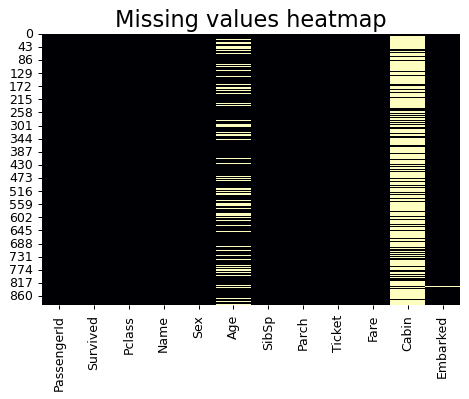

In [19]:
# Ref: For cmap --> https://seaborn.pydata.org/tutorial/color_palettes.html
fig, ax = plt.subplots(dpi = 90)
sns.heatmap(df.isnull(), cmap="magma", cbar = False).set_title("Missing values heatmap", fontsize = 18);

**<font color='teal'>Handling missing values of `Embarked`.</font>**

In [20]:
df.Embarked.value_counts(dropna = False)

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

Since `Embarked` has only two missing values, we will fill the missing values by its `mode` that is the most frequently occurring element in a series.

In [21]:
df.Embarked.mode()

0    S
Name: Embarked, dtype: object

In [22]:
df.Embarked.fillna(df.Embarked.mode()[0], inplace = True)

In [23]:
df.Embarked.value_counts(dropna = False)

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [24]:
count_null_values(df)

,VarName,NullCount
0,Cabin,687
1,Age,177


As the feature `Cabin` has a lot of missing values (687 out of 891), we will drop this feature.

We can impute the `Age` column by using one of the advanced imouting schemes such as `scikit-learn`'s `KNNImputer` (re: [sklearn.impute.KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html)) class or `IterativeImputer` class (re: [sklearn.impute.IterativeImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer)) or the `missingpy` [package](https://pypi.org/project/missingpy/). In this work, we chose `KNNImputer`.

Before imputing the `Age` column, we will one-hot-encode the categorical variables since because most of these imputers needs data to be numerical.

**<font color='teal'>Create dummy features for the categorical features and add those to the `df` dataframe. Make sure to also remove the original categorical columns from the dataframe. Also, drop `PassengerId`, `Name`, `Cabin`, and `Ticket` since they are not useful for prediction.</font>**

In [25]:
dfo.columns

Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object')

In [26]:
df = pd.DataFrame(df.drop(dfo.columns,
                          axis = 1)).merge(pd.get_dummies(dfo.drop(['Name',
                                                                    'Cabin',
                                                                    'Ticket'],
                                                                   axis =1)),
                                           left_index=True,
                                           right_index=True).drop(['PassengerId'],
                                                                  axis = 1)
print(f"\ndf.shape: {df.shape}\n")
df.head()


df.shape: (891, 11)



,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


In [27]:
count_null_values(df)

,VarName,NullCount
0,Age,177


**<font color='teal'>Impute the missing values of `Age` using `KNNImputer`.</font>**

We will plot the histogram of `Age` **before** annd **after** imputation. Let us save the `Age` column before imputation. We will also save the`Sex_male` column, which we will as `hue` patrameter in `seaborn`'s `.histplot`.

In [28]:
data_Age_Sex = df[['Age', 'Sex_male']]

In [29]:
imputer = KNNImputer(n_neighbors=5, weights="distance")
df = pd.DataFrame(imputer.fit_transform(df), columns = df.columns)

If you like to try other imputer, you can refer to this [article](https://towardsdatascience.com/a-better-way-to-handle-missing-values-in-your-dataset-using-iterativeimputer-9e6e84857d98#3be8) for a simple illustration on `IterativeImputer` and this [one](https://towardsdatascience.com/missforest-the-best-missing-data-imputation-algorithm-4d01182aed3) for `missingpy` package.

In [30]:
# # Introduce IterativeImputer with an estimator
# # imp = IterativeImputer()
# imp = IterativeImputer(estimator=RandomForestRegressor(),
#                        initial_strategy = 'most_frequent', max_iter = 20)
# # Fit to the dataset containing missing values
# imp.fit(df)
# # Transform the dataset containing missing values
# df1 = pd.DataFrame(imp.transform(df), columns = df.columns)

Now, plot the histogram of `Age` **before** and **after** imputation. We have already save the `Age` column data before imputation in `data_Age_Sex` dataframe.

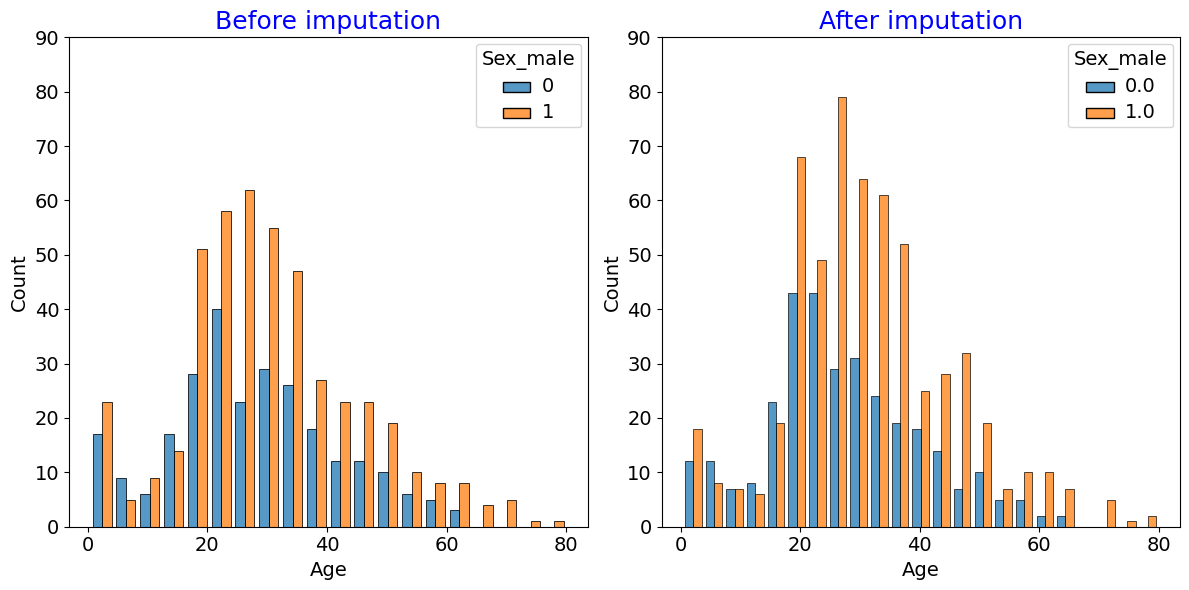

In [31]:
plt.figure(figsize = (12,6), dpi = 100)

#------- Before imputation ----
ax = plt.subplot(121)
fig = sns.histplot(data=data_Age_Sex, x="Age", hue="Sex_male", multiple="dodge", shrink=.8)
ax.set_title("Before imputation", color='blue', fontsize=18)
ax.tick_params(labelsize=14)
ax.set_ylim(top=90)

# Ref: https://www.geeksforgeeks.org/how-to-change-seaborn-legends-font-size-location-and-color/
# for legend text
plt.setp(fig.get_legend().get_texts(), fontsize='14')  
# for legend title
plt.setp(fig.get_legend().get_title(), fontsize='14') 

# Ref: https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
for item in ([ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(14)

    
#------- After imputation ----
ax = plt.subplot(122)
fig = sns.histplot(data=df, x="Age", hue="Sex_male", multiple="dodge", shrink=.8)
ax.set_title("After imputation", color='blue', fontsize=18)
ax.tick_params(labelsize=14)
ax.set_ylim(top=90)

# for legend text
plt.setp(fig.get_legend().get_texts(), fontsize='14')  
# for legend title
plt.setp(fig.get_legend().get_title(), fontsize='14') 

for item in ([ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(14)

plt.tight_layout()
plt.show()

In [32]:
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.0,3.0,22.0,1.0,0.0,7.2500,0.0,1.0,0.0,0.0,1.0
1,1.0,1.0,38.0,1.0,0.0,71.2833,1.0,0.0,1.0,0.0,0.0
2,1.0,3.0,26.0,0.0,0.0,7.9250,1.0,0.0,0.0,0.0,1.0
3,1.0,1.0,35.0,1.0,0.0,53.1000,1.0,0.0,0.0,0.0,1.0
4,0.0,3.0,35.0,0.0,0.0,8.0500,0.0,1.0,0.0,0.0,1.0


**<font color='teal'>Print the null values for each column in the dataframe.</font>**

In [33]:
count_null_values(df)

,VarName,NullCount


**<font color='teal'>Create the X and y matrices from the dataframe, where y = df.Survived </font>**

In [34]:
X = df.drop('Survived', axis=1)
y = df.Survived

**<font color='teal'>Split the `X` and y into 70/10/20 training/validation/testing data subsets.</font>**

In [35]:
# X_train, X_test, y_train, y_test
#         = train_test_split(X, y, test_size=.25, random_state=42, stratify = y)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify = y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.125,
                                                  random_state = 1,
                                                  stratify = y_train)
                                                            # 0.125 x 0.8 = 0.1

**<font color='teal'>Apply the standard scaler to the `X_train` matrix.</font>**

Scale the data after train/test split. Apply the `scaler.transform` obtained from the train split on the test set.

In [36]:
scaler = preprocessing.StandardScaler().fit(X_train)

# Scale the X_train
X_train = scaler.transform(X_train)

# Scale the X_val
X_val = scaler.transform(X_val)

# Scale the X_test
X_test = scaler.transform(X_test)

**<font color='teal'>Run the cell below to test multiple learning rates in your gradient boosting classifier.</font>**

In [37]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, 
                                    learning_rate = learning_rate, 
                                    max_features=2,
                                    max_depth = 2, random_state = 0)
    gb.fit(X_train, y_train)
    print(f"Learning rate: {learning_rate}")
    print(f"Accuracy score (training): {round(gb.score(X_train, y_train),3)}")
    print(f"Accuracy score (val): {round(gb.score(X_val, y_val),3)}")
    print(f"Gap in scroe: {round(gb.score(X_train, y_train)-gb.score(X_val, y_val),3)}\n")

Learning rate: 0.05
Accuracy score (training): 0.831
Accuracy score (val): 0.753
Gap in scroe: 0.079

Learning rate: 0.1
Accuracy score (training): 0.838
Accuracy score (val): 0.764
Gap in scroe: 0.074

Learning rate: 0.25
Accuracy score (training): 0.828
Accuracy score (val): 0.787
Gap in scroe: 0.042

Learning rate: 0.5
Accuracy score (training): 0.857
Accuracy score (val): 0.787
Gap in scroe: 0.071

Learning rate: 0.75
Accuracy score (training): 0.873
Accuracy score (val): 0.775
Gap in scroe: 0.098

Learning rate: 1
Accuracy score (training): 0.873
Accuracy score (val): 0.775
Gap in scroe: 0.098



**<font color='teal'>Apply the best learning rate to the model fit and predict on the testing set. Print out the confusion matrix and the classification report to review the model performance.</font>**

In [38]:
gb = GradientBoostingClassifier(n_estimators=20,
                                learning_rate = 0.25,
                                max_features=2, max_depth = 2,
                                random_state = 0)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.89      0.85       110
         1.0       0.79      0.67      0.72        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



In [40]:
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
cm.columns = ['Predicted 0', 'Predicted 1']
cm.index = ['Actual 0', 'Actual 1']
cm

,Predicted 0,Predicted 1
Actual 0,98,12
Actual 1,23,46


**<font color='teal'>Calculate the ROC for the model as well.</font>**

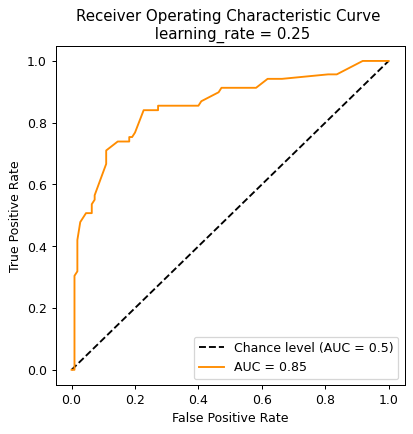

In [41]:
plt.figure(figsize = (5,5), dpi = 90)

ax = plt.subplot(111)

y_score = gb.decision_function(X_test)
roc_auc_area = roc_auc_score(y_test, y_score)

# Ref: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
ax.plot([0,1], [0,1], "k--", label=f"Chance level (AUC = 0.5)")

# Ref: https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_display_object_visualization.html
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_display = RocCurveDisplay(fpr=fpr,
                              tpr=tpr).plot(ax=ax, color="darkorange",
                                            label = f"AUC = {round(roc_auc_area,2)}")

plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Receiver Operating Characteristic Curve \n learning_rate = 0.25')
plt.show()

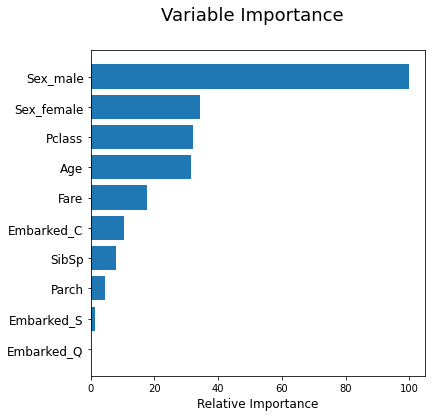

In [42]:
feature_importance = gb.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(6,6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx], fontsize = 12)
plt.xlabel('Relative Importance', fontsize = 12)
plt.suptitle('Variable Importance', fontsize = 18)
plt.show()